## This is an auxillary script which loads trained HDEs and identifies successfully trained ones based a reference HDE that we know is good 

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline
import os, glob, re, pickle
import numpy as np
import pyemma as py
import matplotlib.pyplot as plt 

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="2" 

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/pyemma/__init__.py:130: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.5, you have 2.5.4.
  .format(latest=latest, current=current), category=UserWarning)


In [4]:
import tensorflow as tf
import keras.backend as K
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
def load_hde_models(files):
    scores = []
    models = []
    
    for file in files:
        hde, score = pickle.load(open(file, 'rb'))
        scores.append(score)
        models.append(hde)
    
    models = np.array(models)
    scores = np.array(scores)
    
    return models, scores

def load_hde_models_eval(files, data):
    evals = []
    
    for file in files:
        hde = pickle.load(open(file, 'rb'))
        evals.append(hde.transform(data))
        K.clear_session()
        
    return evals

## Load models 

In [6]:
X = np.load('scaled_features.npy')

In [7]:
files = glob.glob('hde-model-scan/hde_model_*.pkl')
files.sort()
evals = load_hde_models_eval(files, X)

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
tica_viz = py.load('tica_viz.mdl')

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [9]:
tica_viz.dim = 7

In [10]:
tica_viz.fit(X);

In [11]:
W = tica_viz.transform(X)

In [12]:
def find_correlations(evals, refs, tol=0.9):
    matches = []
    for i, Y in enumerate(evals):
        match = True
        for j, cv in enumerate(refs):
            corr = np.sum(Y[:,j]*cv)/len(cv)
            if corr**2 < tol:
                match = False
        if match == True: 
            matches.append(i)
    return matches

In [13]:
ref_cvs = [evals[0][:,0], evals[0][:,1], evals[0][:,2], evals[29][:,3], evals[95][:,4], evals[146][:,5]]
ref_cvs = np.array(ref_cvs)

In [15]:
#pickle.dump(ref_cvs, open('reference_cvs.pkl', 'wb'))

In [16]:
cand_idx = find_correlations(evals, ref_cvs, tol=0.95)

In [17]:
coords = [
    [0, 2],
    [0, 1],
    [0, 2],
    [0, 2],
    [0, 4],
    [5, 6],
    [2, 3]
]

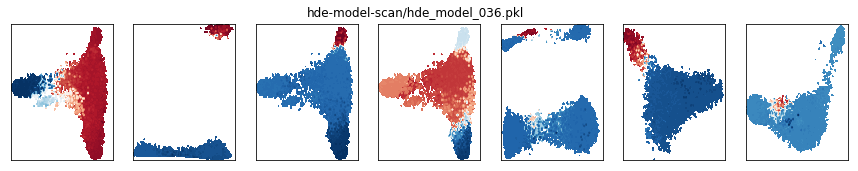

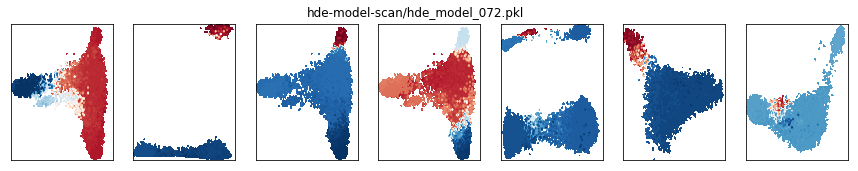

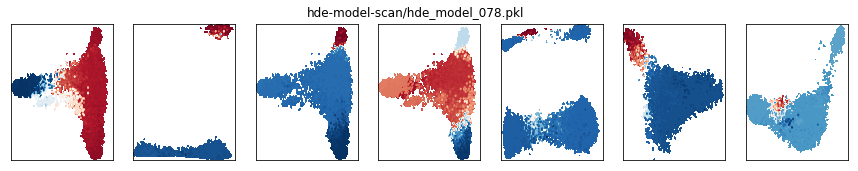

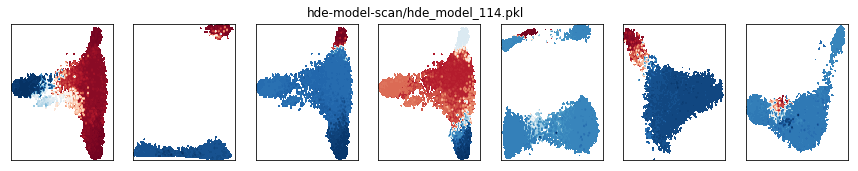

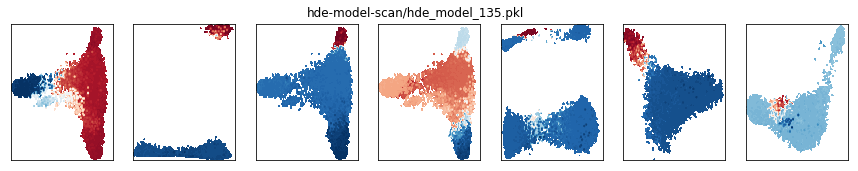

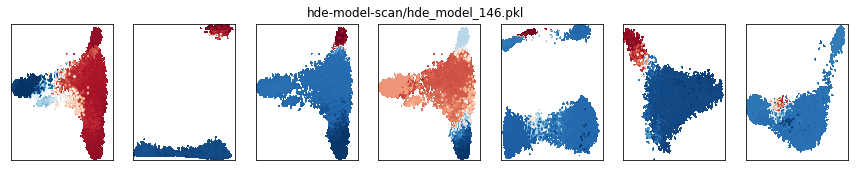

In [19]:
skip = 10

for i in cand_idx:
    Z = evals[i]
    fig, axes = plt.subplots(1, 7, figsize=(15, 2.5))

    for j in range(7):
        ax = axes[j]
        
        ti, tj = coords[j]
        
        if np.sum(Z[:,j]*W[:, tj]) < 0:
            flip = 1
        else:
            flip = -1
        
        py.plots.plot_contour(
            *W[::skip, [ti, tj]].T,
            flip*Z[::skip, j],
            ax=ax, 
            cmap=plt.cm.RdBu,
            cbar=False,
            mask=True
        )
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.suptitle(files[i])
        
    plt.show()
